<a href="https://colab.research.google.com/github/littlekii/DPBBP/blob/main/DP_MCdrop_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1)one can change the following version into non-dp version by setting **disable_dp **

In [ ]:
!git clone https://github.com/JavierAntoran/Bayesian-Neural-Networks.git
!git clone https://github.com/knamdar/data.git

fatal: destination path 'Bayesian-Neural-Networks' already exists and is not an empty directory.
fatal: destination path 'data' already exists and is not an empty directory.


In [ ]:
!pip install opacus==0.13

In [ ]:
import sys;sys.path.append("/content/Bayesian-Neural-Networks")

# Import base pacage

In [ ]:
import opacus
import numpy as np
import torch

import torch.optim as optim
import opacus
from opacus import PrivacyEngine
from opacus.utils.uniform_sampler import UniformWithReplacementSampler
from torchvision import datasets, transforms
from tqdm import tqdm

# Define MC dropout

## Linear Layers

In [ ]:
from src.priors import *
from src.base_net import *

import torch.nn.functional as F
import torch.nn as nn


def MC_dropout(act_vec, p=0, mask=True):
    return F.dropout(act_vec, p=p, training=mask, inplace=True)


class Linear_2L(nn.Module):
    def __init__(self, input_dim, output_dim, n_hid):
        super(Linear_2L, self).__init__()  # what 

        self.pdrop = 0.5  # what 

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc1 = nn.Linear(input_dim, n_hid)
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc3 = nn.Linear(n_hid, output_dim)

        # choose your non linearity
        # self.act = nn.Tanh()
        # self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        # self.act = nn.ELU(inplace=True)
        # self.act = nn.SELU(inplace=True)

    def forward(self, x, sample=True):
        mask = self.training or sample  # if training or sampling, mc dropout will apply random binary mask
        # Otherwise, for regular test set evaluation, we can just scale activations

        x = x.view(-1, self.input_dim)  # view(batch_size, input_dim)
        # -----------------
        x = self.fc1(x)
        x = MC_dropout(x, p=self.pdrop, mask=mask)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.fc2(x)
        x = MC_dropout(x, p=self.pdrop, mask=mask)
        # -----------------
        x = self.act(x)
        # -----------------
        y = self.fc3(x)

        return y

    def sample_predict(self, x, Nsamples):
        # Just copies type from x, initializes new vector
        predictions = x.data.new(Nsamples, x.shape[0], self.output_dim)

        for i in range(Nsamples):
            y = self.forward(x, sample=True)
            predictions[i] = y

        return predictions


class MC_drop_net2(BaseNet):
    eps = 1e-6
    # what
    def __init__(self, lr=1e-3, channels_in=3, side_in=28, cuda=True, classes=10, batch_size=128, weight_decay=0, n_hid=1200,sr=0.004,sigma=1,max_grad_norm=1.0,secure_rng=False):
        super(MC_drop_net2, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.weight_decay = weight_decay
        self.sr = sr
        self.disable_dp = disable_dp      
        self.sigma = sigma
        self.max_grad_norm = max_grad_norm
        self.secure_rng = secure_rng
        self.classes = classes
        self.n_hid = n_hid
        self.batch_size = batch_size
        self.side_in = side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0
        self.test = False

    # main net and use GPU 
    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)
        # what 
        self.model = Linear_2L(input_dim=self.channels_in * self.side_in * self.side_in, output_dim=self.classes,
                               n_hid=self.n_hid)
        if self.cuda:
            self.model.cuda()
        #             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))
    
    # optimizer 
    def create_opt(self):
        #         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
        #                                           weight_decay=0)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.5,
                                         weight_decay=self.weight_decay)

        if not disable_dp:
            privacy_engine = PrivacyEngine(
                self.model,
                sample_rate=self.sr,
                alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
                noise_multiplier=self.sigma,
                max_grad_norm=self.max_grad_norm,
                secure_rng=self.secure_rng,
            )
            privacy_engine.attach(self.optimizer) # make optimizer private 
    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
    #         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)
   
    # train 
    def fit(self, x, y):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        self.optimizer.zero_grad()

        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='sum')

        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()
        return loss.data, err
    # test 
    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def sample_eval(self, x, y, Nsamples, logits=True, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model.sample_predict(x, Nsamples)

        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()

        else:
            mean_out = F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()

            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def all_sample_eval(self, x, y, Nsamples):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model.sample_predict(x, Nsamples)

        prob_out = F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out

    def get_weight_samples(self):
        weight_vec = []

        state_dict = self.model.state_dict()

        for key in state_dict.keys():

            if 'weight' in key:
                weight_mtx = state_dict[key].cpu().data
                for weight in weight_mtx.view(-1):
                    weight_vec.append(weight)

        return np.array(weight_vec)

## Convolutional Layers

In [ ]:
# from src.priors import *
# from src.base_net import *

# import torch.nn.functional as F
# import torch.nn as nn


# def MC_dropout(act_vec, p=0, mask=True):
#     return F.dropout(act_vec, p=p, training=mask, inplace=True)


# class SampleConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 16, 8, 2, padding=3)
#         self.conv2 = nn.Conv2d(16, 32, 4, 2)
#         self.fc1 = nn.Linear(32 * 4 * 4, 32)
#         self.fc2 = nn.Linear(32, 10)

#     def forward(self, x):
#         # x of shape [B, 1, 28, 28]
#         x = F.relu(self.conv1(x))  # -> [B, 16, 14, 14]
#         x = F.max_pool2d(x, 2, 1)  # -> [B, 16, 13, 13]
#         x = F.relu(self.conv2(x))  # -> [B, 32, 5, 5]
#         x = F.max_pool2d(x, 2, 1)  # -> [B, 32, 4, 4]
#         x = x.view(-1, 32 * 4 * 4)  # -> [B, 512]
#         x = F.relu(self.fc1(x))  # -> [B, 32]
#         x = self.fc2(x)  # -> [B, 10]
#         return x

#     def name(self):
#         return "SampleConvNet"


#     def sample_predict(self, x, Nsamples):
#         # Just copies type from x, initializes new vector
#         predictions = x.data.new(Nsamples, x.shape[0], self.output_dim)

#         for i in range(Nsamples):
#             y = self.forward(x, sample=True)
#             predictions[i] = y

#         return predictions


# class MC_drop_net2(BaseNet):
#     eps = 1e-6
#     # what
#     def __init__(self, lr=1e-3, channels_in=3, side_in=28, cuda=True, classes=10, batch_size=128, weight_decay=0, n_hid=1200,sr=0.004,sigma=1,max_grad_norm=1.0,secure_rng=False):
#         super(MC_drop_net2, self).__init__()
#         cprint('y', ' Creating Net!! ')
#         self.lr = lr
#         self.schedule = None  # [] #[50,200,400,600]
#         self.cuda = cuda
#         self.channels_in = channels_in
#         self.weight_decay = weight_decay
#         self.sr = sr
#         self.disable_dp = disable_dp      
#         self.sigma = sigma
#         self.max_grad_norm = max_grad_norm
#         self.secure_rng = secure_rng
#         self.classes = classes
#         self.n_hid = n_hid
#         self.batch_size = batch_size
#         self.side_in = side_in
#         self.create_net()
#         self.create_opt()
#         self.epoch = 0
#         self.test = False

#     # main net and use GPU 
#     def create_net(self):
#         torch.manual_seed(42)
#         if self.cuda:
#             torch.cuda.manual_seed(42)
#         # what 
#         self.model = SampleConvNet(input_dim=self.channels_in * self.side_in * self.side_in, output_dim=self.classes,
#                                n_hid=self.n_hid)
#         if self.cuda:
#             self.model.cuda()
#         #             cudnn.benchmark = True

#         print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))
    
#     # optimizer 
#     def create_opt(self):
#         #         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
#         #                                           weight_decay=0)
#         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.5,
#                                          weight_decay=self.weight_decay)

#         if not disable_dp:
#             privacy_engine = PrivacyEngine(
#                 self.model,
#                 sample_rate=self.sr,
#                 alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
#                 noise_multiplier=self.sigma,
#                 max_grad_norm=self.max_grad_norm,
#                 secure_rng=self.secure_rng,
#             )
#             privacy_engine.attach(self.optimizer) # make optimizer private 
#     #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
#     #         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)
   
#     # train 
#     def fit(self, x, y):
#         x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

#         self.optimizer.zero_grad()

#         out = self.model(x)
#         loss = F.cross_entropy(out, y, reduction='sum')

#         loss.backward()
#         self.optimizer.step()

#         # out: (batch_size, out_channels, out_caps_dims)
#         pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
#         err = pred.ne(y.data).sum()
#         return loss.data, err
#     # test 
#     def eval(self, x, y, train=False):
#         x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

#         out = self.model(x)

#         loss = F.cross_entropy(out, y, reduction='sum')

#         probs = F.softmax(out, dim=1).data.cpu()

#         pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
#         err = pred.ne(y.data).sum()

#         return loss.data, err, probs

#     def sample_eval(self, x, y, Nsamples, logits=True, train=False):
#         x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

#         out = self.model.sample_predict(x, Nsamples)

#         if logits:
#             mean_out = out.mean(dim=0, keepdim=False)
#             loss = F.cross_entropy(mean_out, y, reduction='sum')
#             probs = F.softmax(mean_out, dim=1).data.cpu()

#         else:
#             mean_out = F.softmax(out, dim=2).mean(dim=0, keepdim=False)
#             probs = mean_out.data.cpu()

#             log_mean_probs_out = torch.log(mean_out)
#             loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

#         pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
#         err = pred.ne(y.data).sum()

#         return loss.data, err, probs

#     def all_sample_eval(self, x, y, Nsamples):
#         x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

#         out = self.model.sample_predict(x, Nsamples)

#         prob_out = F.softmax(out, dim=2)
#         prob_out = prob_out.data

#         return prob_out

#     def get_weight_samples(self):
#         weight_vec = []

        # state_dict = self.model.state_dict()

        # for key in state_dict.keys():

        #     if 'weight' in key:
        #         weight_mtx = state_dict[key].cpu().data
        #         for weight in weight_mtx.view(-1):
        #             weight_vec.append(weight)

        # return np.array(weight_vec)

# Global Parameters

In [ ]:
#from __future__ import division, print_function
import time
import torch.utils.data
from torchvision import transforms, datasets
from src.MC_dropout.model import *

#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
## global 
weight_decay  = 0

models_dir    = 'MCdrop_models'
results_dir   = 'MCdrop_results'

batch_size = 256
sr      = batch_size/60000
test_batch_size  = 1024 
sigma            = 1.3
delta            = 1e-5
max_per_sample_grad_norm = 200
epochs           = 15
n_runs           = 1
lr               = 0.0002
device           = "cuda"
save_model       = False
secure_rng       = False
data_root        = "/content/data/"
disable_dp       = True




# Where to save models weights
models_dir = models_dir
# Where to save plots and error, accuracy vectors
results_dir = results_dir

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
nb_epochs = epochs
log_interval = 1


# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()


trainset = datasets.MNIST(root=data_root, train=True, download=False, transform=transform_train)
valset = datasets.MNIST(root=data_root, train=False, download=False, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=2)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=2)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=2)

## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


Data:

Network:


# Training on MNIST

In [ ]:

########################################################################################

net = MC_drop_net2(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                  weight_decay=weight_decay, n_hid=1200,sr=sr,sigma=sigma,max_grad_norm=max_per_sample_grad_norm,secure_rng=secure_rng)

## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(0, nb_epochs):

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0
   
    for x, y in trainloader:

        cost_pred, err = net.fit(x, y)

        err_train[i] += err
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i+1, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))
    
    if not disable_dp:
        epsilon, best_alpha = net.optimizer.privacy_engine.get_privacy_spent(delta)
        print(
            f"(ε = {epsilon:.2f}, δ = {delta}) for α = {best_alpha}"
        )

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir+'/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))

## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)




Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 1/15, Jtr_pred = 0.537704, err = 0.157533,    time: 7.639049 seconds

    Jdev = 0.269703, err = 0.082300

best test error
Writting MCdrop_models/theta_best.dat

it 2/15, Jtr_pred = 0.239564, err = 0.071367,    time: 7.747497 seconds

    Jdev = 0.191328, err = 0.057800

best test error
Writting MCdrop_models/theta_best.dat

it 3/15, Jtr_pred = 0.177665, err = 0.052500,    time: 7.542337 seconds

    Jdev = 0.159575, err = 0.050100

best test error
Writting MCdrop_models/theta_best.dat

it 4/15, Jtr_pred = 0.146215, err = 0.044233,    time: 7.621296 seconds

    Jdev = 0.137449, err = 0.044700

best test error
Writting MCdrop_models/theta_best.dat

it 5/15, Jtr_pred = 0.122192, err = 0.037850,    time: 7.487250 seconds

    Jdev = 0.123069, err = 0.037600

best test error
Writting MCdrop_models/theta_best.dat

it 6/15, Jtr_pred = 0.107547, err = 0.032450,    time: 7.506015 seconds

    Jdev = 0.109180, err

#Calibration

In [ ]:
# if necessary, one should load the local model to produce the following graphs
#model_local = MC_drop_net2(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
#                  weight_decay=weight_decay, n_hid=1200,sr=sr,sigma=sigma,max_grad_norm=max_per_sample_grad_norm,secure_rng=secure_rng)
#model_local.load('/content/theta_best.dat')


In [ ]:
#model_local.to(device)
#model_local.eval()
y_local_te=np.empty((0,10))
targets_te=np.array([])
prob_local=np.array([])
acc = 0 
with torch.no_grad():
        for data, target in tqdm(valloader):
            data, target = data.to(device), target.to(device)
            cost, err, prob = net.eval(data,target)
            acc += err
            y_local_te=np.append(y_local_te,prob.detach().numpy(),axis=0)
            #y_local_te_single=np.append(y_local_te_single,y_local_te[-1].argmax())
            prob_local=np.append(prob,np.array([prob.detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy())]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())

y_local_te_single= np.argmax(y_local_te,axis=1)


100%|██████████| 40/40 [00:01<00:00, 25.59it/s]


In [ ]:
sum(y_local_te_single==targets_te)/10000 - np.mean(np.max(y_local_te,axis=1))

-0.002523571318387985

######## ECE: ##############


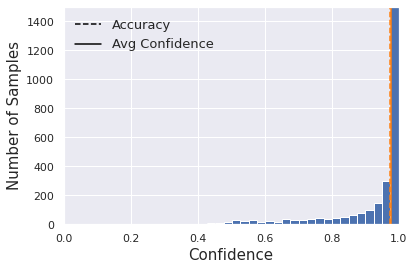

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


#local_acc = np.mean(y_local_te_single == targets_te)


print("######## ECE: ##############")
#print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}, ECE {np.abs(local_acc - np.mean(np.max(y_local_te,axis=1)))}")
#print(f"NonDP accuracy: {nondp_acc}, predicted confidence {np.mean(np.max(y_nondp_te,axis=1))}, ECE {np.abs(nondp_acc - np.mean(np.max(y_nondp_te,axis=1)))}")


plt.plot(0,0,linestyle='dashed',color='black')
plt.plot(0,0,color='black')
plt.plot(0,0,color='#1f77b4')
plt.plot(0,0,color='#ff7f0e')
#plt.plot([0.2338]*20,np.linspace(0,1500,20),linestyle='dashed',color='#1f77b4')
plt.plot([sum(y_local_te_single==targets_te)/10000]*20,np.linspace(0,1500,20),linestyle='dashed',color='#ff7f0e',label='local Accu')
#plt.plot([np.mean(np.max(y_global_te,axis=1))]*20,np.linspace(0,1500,20),color='#1f77b4')
plt.plot([np.mean(np.max(y_local_te,axis=1))]*20,np.linspace(0,1500,20),color='#ff7f0e')

#print('non DP accuracy:', np.mean(targets_te==y_noDP_te_single),' confidence:',np.mean(np.max(y_noDP_te,axis=1)),' difference:',np.mean(np.max(y_noDP_te,axis=1))-np.mean(targets_te==y_noDP_te_single))
#print('DP local accuracy:', np.mean(targets_te==y_local_te_single),' confidence:',np.mean(np.max(y_local_te,axis=1)),' difference:',np.mean(np.max(y_local_te,axis=1))-np.mean(targets_te==y_local_te_single))
#print('DP global accuracy:', np.mean(targets_te==y_global_te_single),' confidence:',np.mean(np.max(y_global_te,axis=1)),' difference:',np.mean(np.max(y_global_te,axis=1))-np.mean(targets_te==y_global_te_single))

plt.hist(np.max(y_local_te,axis=1),bins=30)
plt.ylim(0,1500)
plt.xlim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Number of Samples', fontsize=15)
plt.legend(('Accuracy','Avg Confidence'),fontsize=13,loc='upper left',frameon=False)
plt.savefig('Confidence_DPMCD.pdf',format='pdf')
plt.show()



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


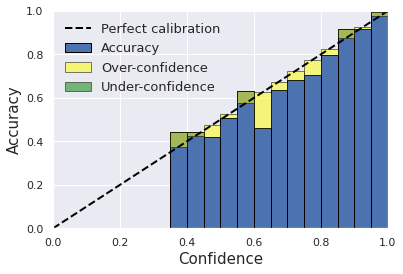

0.16346153846153855

In [ ]:
#%%
store_local = []
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0

#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.savefig('Confidence_MNIST_detail_LOCAL.pdf',format='pdf')
plt.show()

max(abs((xaxis[store_local!=0]-store_local[store_local!=0])))


# Prediction Uncertainty 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


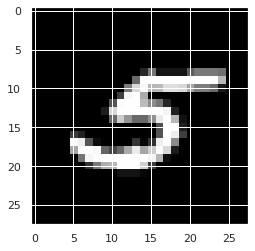

7531 tensor([5]) tensor([1]) tensor([[0.0137, 0.1875, 0.0583, 0.0682, 0.1357, 0.1573, 0.0673, 0.1235, 0.0927,
         0.0959]])


In [ ]:
# set batch_size = 1 and find which index of the graph in the testloader is not predicted well by the current method 
# condition I err.cpu().detach().numpy()==1 : prediction is wrong 
# condition II np.max(probs.cpu().detach().numpy())<0.2 : unconfident prediction 
valloader_plot = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)
import torchvision

for j, (x, y) in enumerate(valloader_plot):
    cost, err, probs = net.eval(x, y)
    if err.cpu().detach().numpy()==1 and np.max(probs.cpu().detach().numpy())<0.2:
      img=torchvision.utils.make_grid(x*0.3081+0.1307)
      plt.imshow(np.transpose(img, (1, 2, 0)))
      plt.show()
      print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


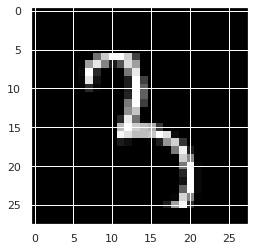

195 tensor([3]) tensor([3]) tensor([[0.0066, 0.1409, 0.0386, 0.2575, 0.1242, 0.1673, 0.0307, 0.0648, 0.0522,
         0.1173]])


<Figure size 432x288 with 0 Axes>

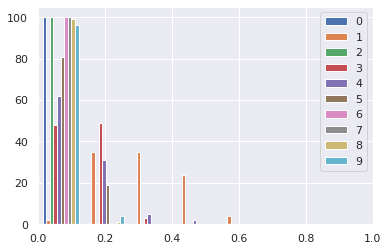

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


404 tensor([2]) tensor([2]) tensor([[0.0700, 0.0657, 0.5335, 0.0755, 0.0006, 0.0607, 0.0103, 0.0079, 0.1746,
         0.0013]])


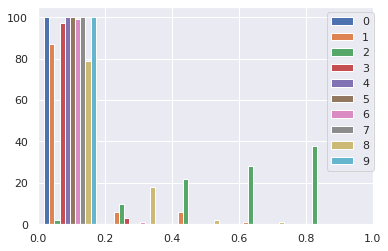

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==195:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break


prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])

fig, ax = plt.subplots(nrows=1, ncols=1)

plt.hist(prob_list,bins=5)
plt.xlim([0,1])
plt.legend(['0','1','2','3','4','5','6','7','8','9'],loc='upper right')
plt.savefig('dp_mcb_hist3.pdf',bbox_inches = 'tight')

plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

hist_prob = []
err_rate = 0
for j, (x, y) in enumerate(valloader_plot):
  if j==404:
    for i in range(100):
      cost, err, probs = net.sample_eval(x, y,1,logits=False)
      hist_prob.append(np.array(probs.cpu().detach().numpy())[0])
      err_rate += err.cpu().detach().numpy()
    img=torchvision.utils.make_grid(x*0.3081+0.1307)
    #plt.imshow(np.transpose(img, (1, 2, 0)))
    #plt.show()
    #plt.savefig('uncertain_number',bbox_inches = 'tight')
    print(j,y,probs.data.max(dim=1, keepdim=False)[1],probs)
    break


prob_list = [[],[],[],[],[],[],[],[],[],[]]

k = 0
for l in hist_prob:
    for k in range(10):
      prob_list[k].append(l[k])

fig, ax = plt.subplots(nrows=1, ncols=1)

plt.hist(prob_list,bins=5)
plt.xlim([0,1])
plt.legend(['0','1','2','3','4','5','6','7','8','9'],loc='upper right',bbox_to_anchor=(1.02,1))
plt.savefig('dp_mcb_hist2.pdf',bbox_inches = 'tight')
plt.show()




# Hetero Regression 

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install GPy

import pandas as pd
import zipfile
import urllib.request
import os
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD
from sklearn.model_selection import KFold

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

ERROR: torch-0.4.1-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.
     |████████████████████████████████| 962kB 4.3MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565026 sha256=a1228882a82c85d4819d30c68f1b75ec7829f0a98e1dc65efe780da3b76fbbbe
  Stored in directory: /root/.cache/pip/wheels/23/99/8d/d0c3dee7db4af58190cde6abdb45e6a7ded2f9f01ff528dd0f
  Created wheel for paramz: filename=paramz-0.9.5-cp37-none-any.whl size=102566 sha256=0aac6dd0daca92cc01a494cdd6a772e0971cd81dd8f48252d8044603ce2b9b3a
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [ ]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out
    def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()
class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob
        
        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, 2*output_dim)
        
        self.activation = nn.ReLU(inplace = True)

    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        x = self.layer2(x)
        
        return x
class MC_Dropout_Wrapper:
    def __init__(self, network, learn_rate, batch_size, weight_decay):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
        
        loss.backward()
        self.optimizer.step()

        return loss, output[:, :1]
    
    def get_loss_and_rmse(self, x, y, num_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(num_samples):
            output = self.network(x)
            means.append(output[:, :1])
            stds.append(output[:, 1:].exp())
        
        means, stds = torch.cat(means, dim=1), torch.cat(stds, dim=1)
        mean = means.mean(dim=-1)[:, None]
        std = ((means.var(dim=-1) + stds.mean(dim=-1)**2)**0.5)[:, None]
        loss = self.loss_func(mean, y, std, 1)
        
        rmse = ((mean - y)**2).mean()**0.5

        return loss.detach().cpu(), rmse.detach().cpu()

## Train on the regression model 

In [ ]:
np.random.seed(5)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

print(x_train.shape, y_train.shape)
num_epochs, batch_size = 2000, len(x_train)

net = MC_Dropout_Wrapper(network=MC_Dropout_Model(input_dim=1, output_dim=1, num_units=200, drop_prob=0.5),
                         learn_rate=1e-4, batch_size=batch_size, weight_decay=1e-2)

fit_loss_train = np.zeros(num_epochs)
best_net, best_loss = None, float('inf')
nets, losses = [], []

for i in range(num_epochs):
    
    loss = net.fit(x_train, y_train)[0]
    y_hat = net.fit(x_train, y_train)[1] 
    if i % 200 == 0:
        print('Epoch: %4d, Train loss = %7.3f' % (i, loss.cpu().data.numpy()/batch_size))
np.power((y_hat.cpu().data.numpy()-y_train),2).sum()/250

(250, 1) (250, 1)
Epoch:    0, Train loss =   2.090
Epoch:  200, Train loss =   0.958
Epoch:  400, Train loss =   0.914
Epoch:  600, Train loss =   0.926
Epoch:  800, Train loss =   1.065
Epoch: 1000, Train loss =   0.886
Epoch: 1200, Train loss =   0.854
Epoch: 1400, Train loss =   0.901
Epoch: 1600, Train loss =   0.887
Epoch: 1800, Train loss =   0.899


## Prediction Uncertainty of Regression model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

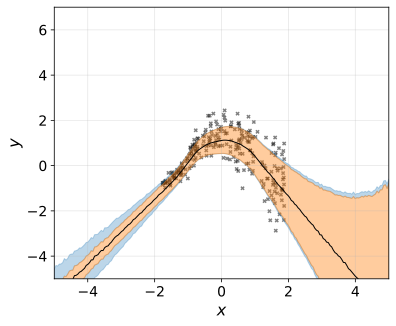

In [ ]:
samples = []
noises = []
for i in range(1000):
    preds = net.network.forward(torch.linspace(-5, 5, 200).cuda()).cpu().data.numpy()
    samples.append(preds[:, 0])
    noises.append(np.exp(preds[:, 1]))
    
samples = np.array(samples)
noises = np.array(noises)
means = (samples.mean(axis = 0)).reshape(-1)

aleatoric = (noises**2).mean(axis = 0)**0.5
epistemic = (samples.var(axis = 0)**0.5).reshape(-1)
total_unc = (aleatoric**2 + epistemic**2)**0.5


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
#plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2),fontsize=14)
plt.yticks(np.arange(-4, 7, 2),fontsize=14)
#plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('mcd_hetero.pdf', bbox_inches = 'tight')

files.download("mcd_hetero.pdf")

plt.show()